### Import Library

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.api import VAR

import sys
sys.path.insert(1, "/Users/yeojisu/Documents/House-Price-Index-Prediction")

from utils.data_loader import *
from config.config_KR import *

### Load Data

In [8]:
target_df = load_target_data(TARGET_PATH)
df = load_feature_data(FEATURE_PATH, FEATURE_COLUMN, TRAIN_DATE)

df = pd.concat([df,target_df],axis = 1) 
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

data_diff = df.diff().dropna()

### Train and forecast

In [ ]:
train, test = data_diff[data_diff.index<TEST_DATE], data_diff[data_diff.index>=TEST_DATE]

var_model = VAR(train)
var_model_fitted = var_model.fit(WINDOW_SIZE)
forecasted_levels = []  # Store the raw values
forecast_dates = []     # Store the dates
for i in range(len(data_diff)- WINDOW_SIZE + 1):
    window_data = data_diff.iloc[i:i+WINDOW_SIZE].values # Retreive window data
    forecast_diff = var_model_fitted.forecast(window_data, steps = FORECAST_HORIZON) # FORECAST_HORIZON steps ahead
    # Compute the cumulative sum of the differenced forecast values
    forecast_diff_cumsum = forecast_diff.cumsum(axis=0)[-1]  # shape: (n,) # Last value = FORECAST_HORIZON
    if i + WINDOW_SIZE < len(df):
        last_level = df.iloc[i + WINDOW_SIZE]
    else:
        continue
    # Predicted (t+windowsize) = reference level + cumulative predicted differenced values
    pred_level = last_level + forecast_diff_cumsum
    forecasted_levels.append(pred_level)
    # The date corresponding to t+windowsize is at index i+windowsize+forecastsize in df.
    if i + WINDOW_SIZE + FORECAST_HORIZON < len(df):
        forecast_date = df.index[i+WINDOW_SIZE+FORECAST_HORIZON]
    else:
        last_date = pd.to_datetime(df.index[-1])
        offset_periods = (i + WINDOW_SIZE + FORECAST_HORIZON) - (len(df)-1)
        forecast_date = last_date + pd.DateOffset(months=offset_periods)
    forecast_dates.append(forecast_date)
forecast_df = pd.DataFrame(forecasted_levels, index=forecast_dates, columns=df.columns)

/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Example plot

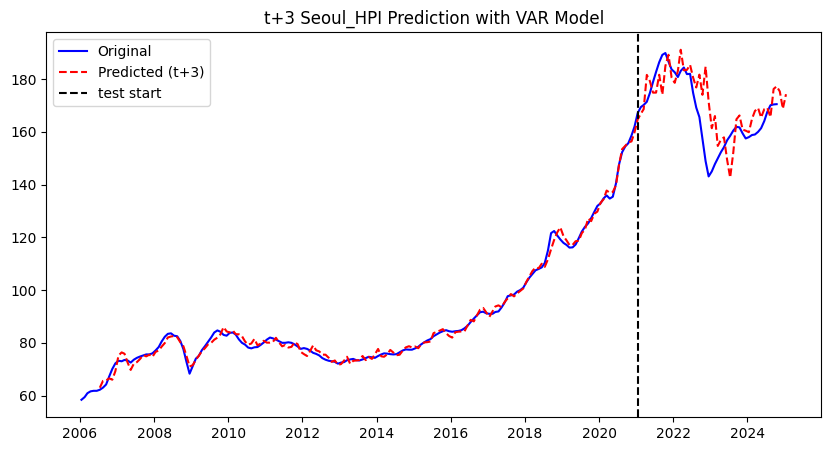

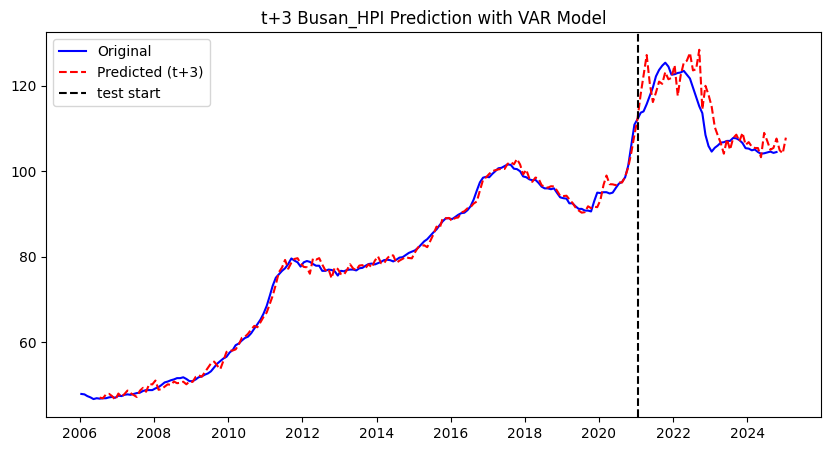

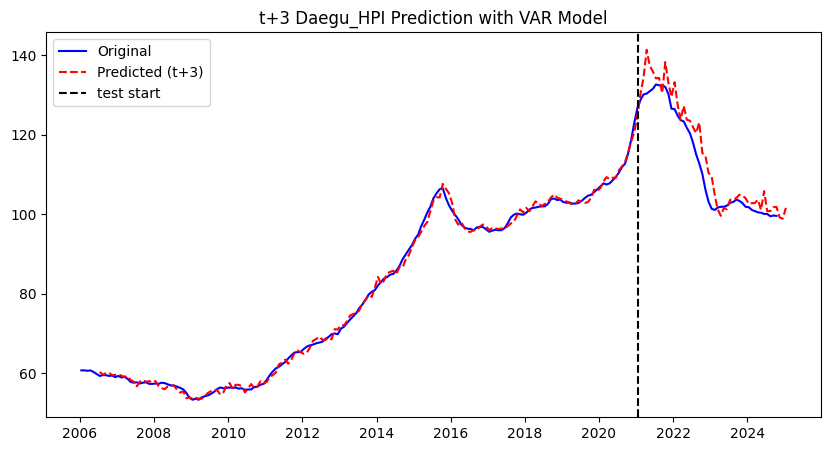

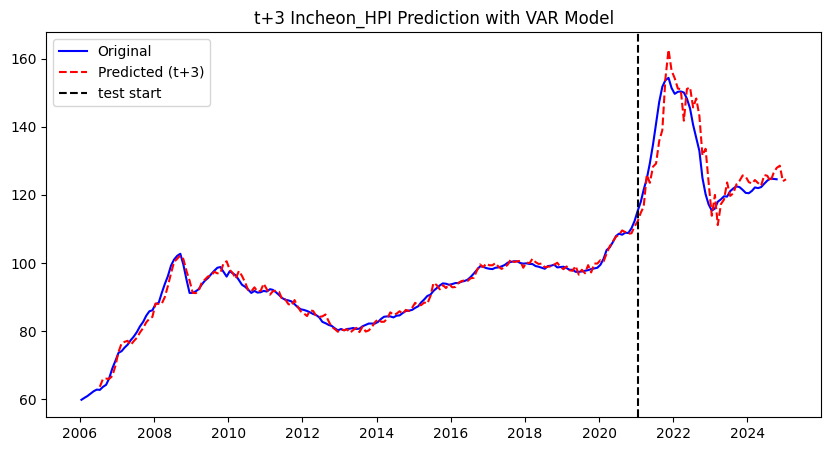

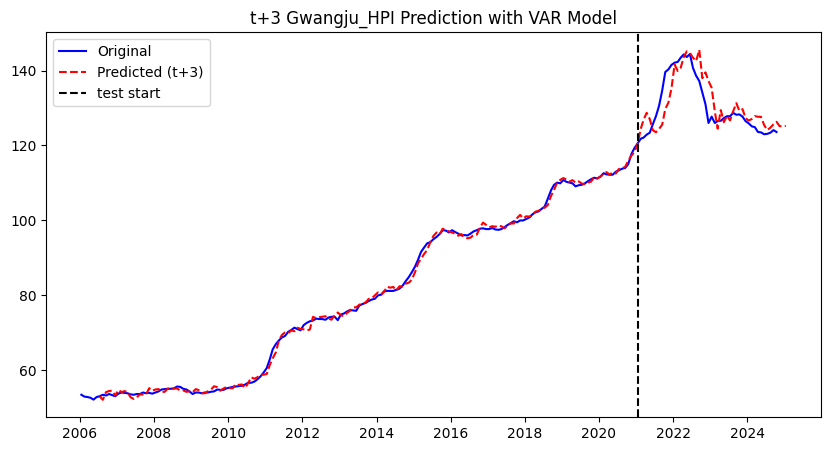

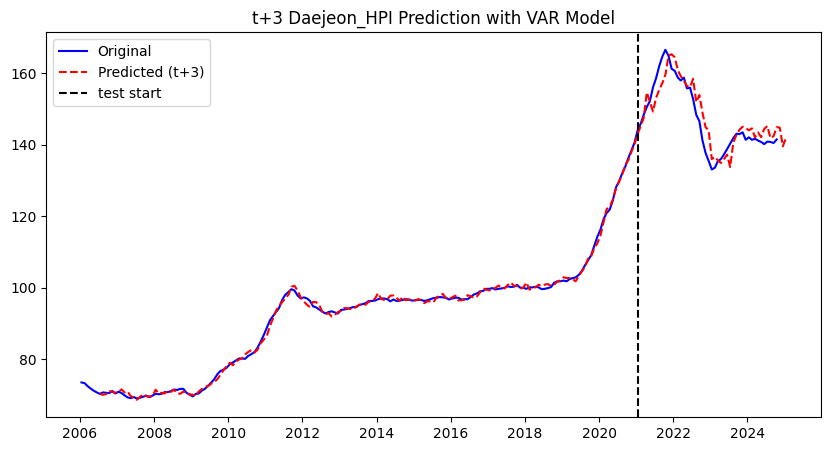

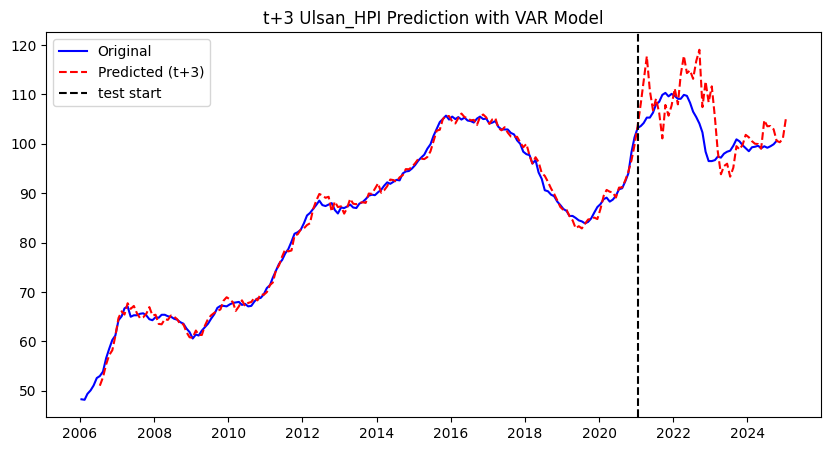

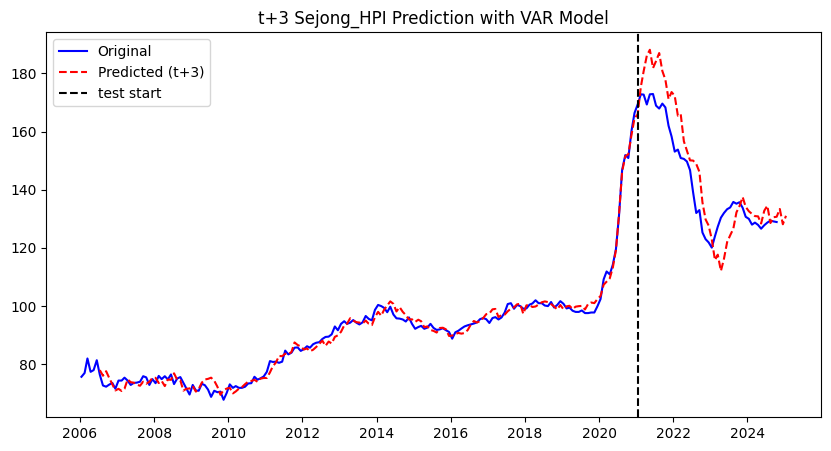

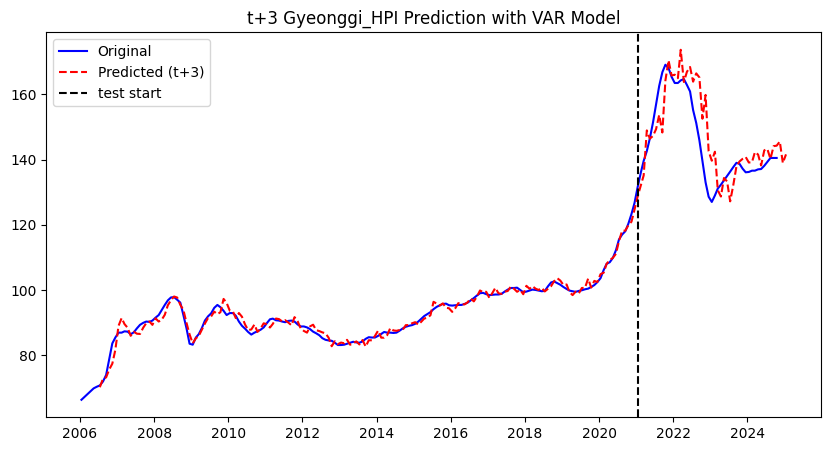

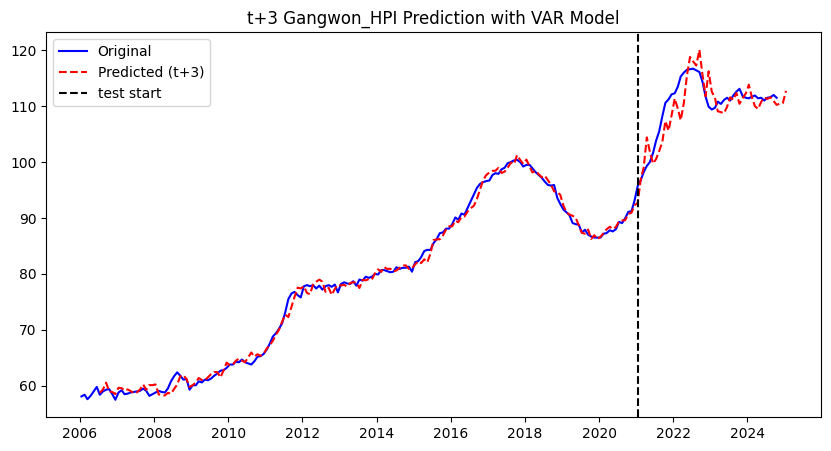

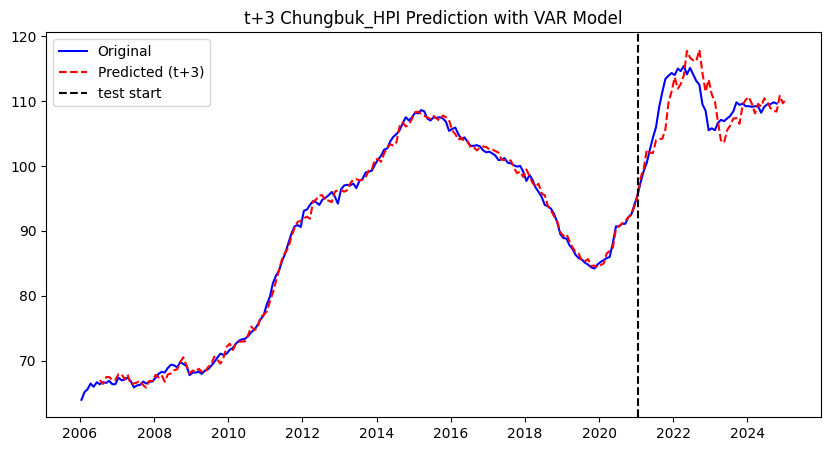

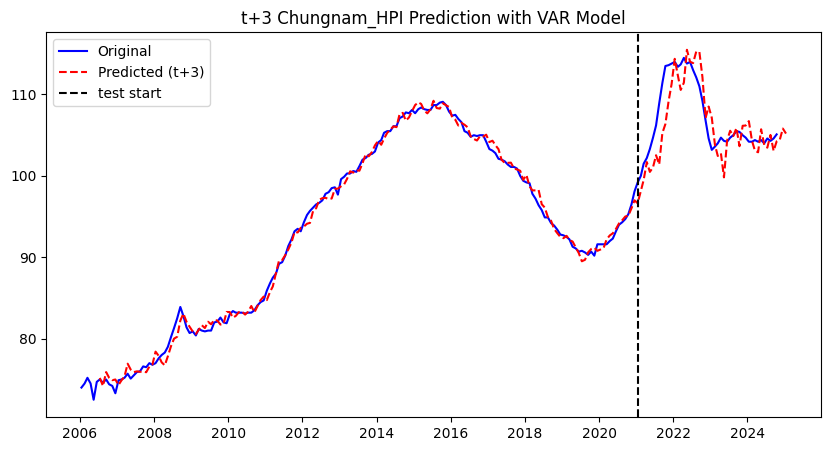

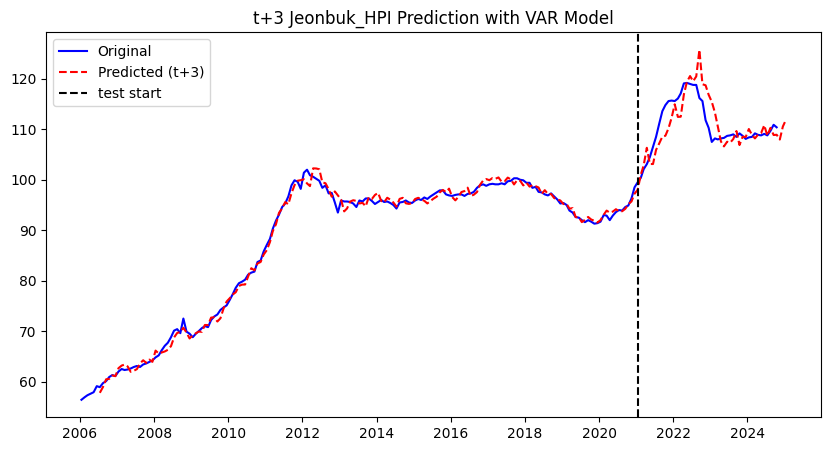

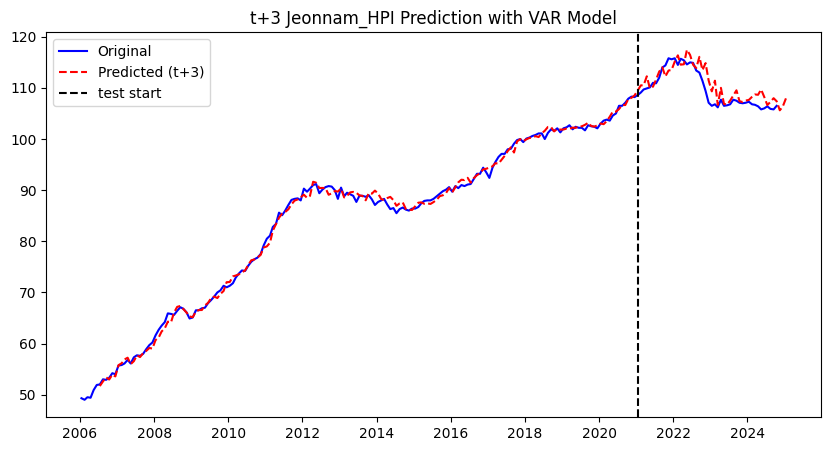

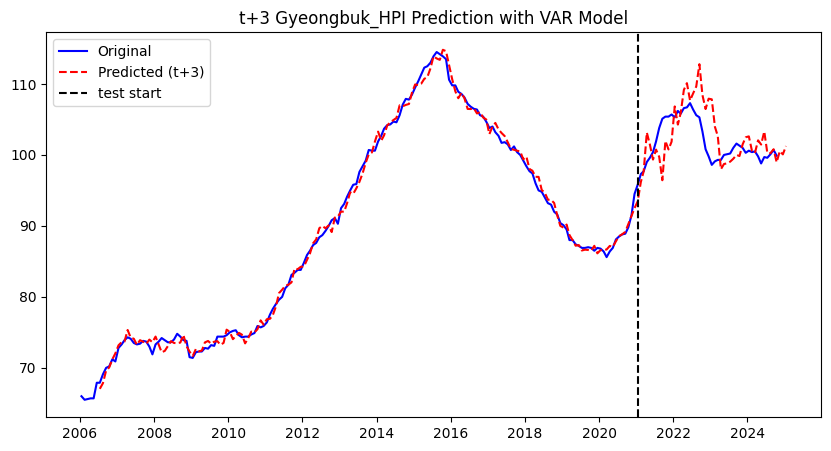

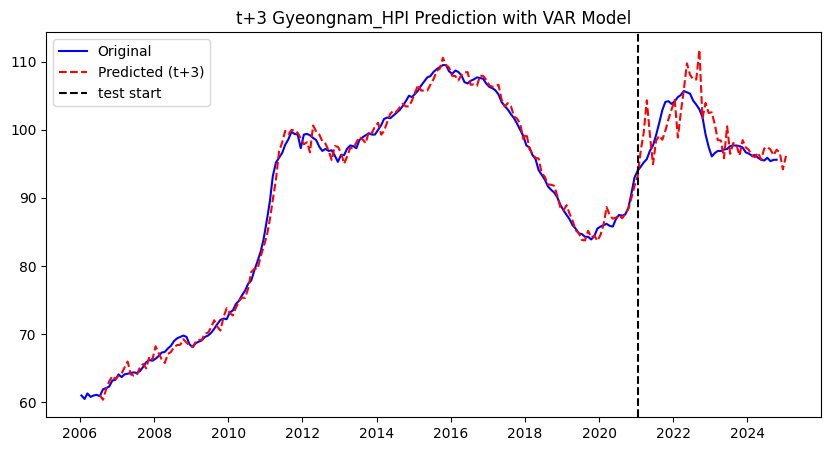

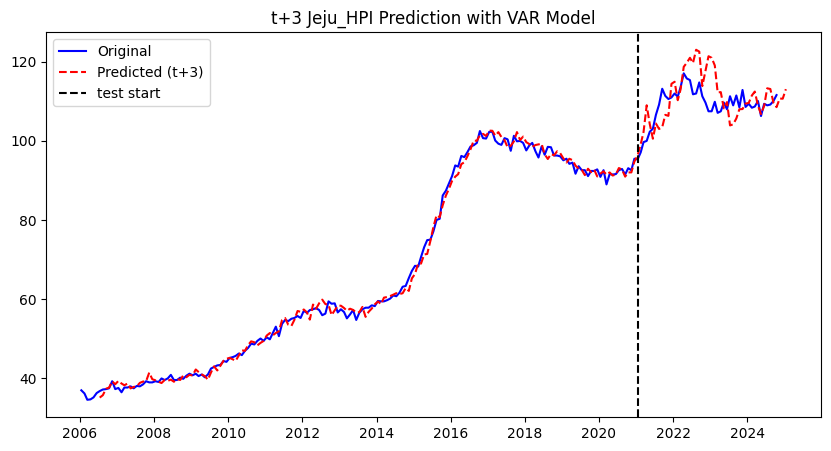

In [10]:
model_name = "VAR"
dir_path = f"/Users/yeojisu/Documents/HPI-Save/Korea/Baseline/traditional/{FORECAST_HORIZON}_{model_name}.csv"

for target in target_df.columns:
    real = df[target]["2021-01-15":"2024-10-15"]
    pred = forecast_df[target]["2021-01-15":"2024-10-15"]
    
    rmse = round(mean_squared_error(real, pred)**0.5,3)
    mae = round(mean_absolute_error(real, pred),3)
    val =[target.split("_")[0],rmse,mae]
    
#     pd.DataFrame(val).T.to_csv(dir_path, mode='a', header=False, index=False)
    
    plt.figure(figsize=(10, 5))
    plt.plot(pd.to_datetime(df.index), df[target], label="Original", color="blue")
    plt.plot(pd.to_datetime(forecast_df.index), forecast_df[target], 
            label=f"Predicted (t+{FORECAST_SIZE})", linestyle="dashed", color="red")
    plt.axvline(pd.to_datetime('2021-01-15'),color="black", linestyle="--", label = "test start")
    plt.legend()
    plt.title(f"t+{FORECAST_SIZE} {target} Prediction with VAR Model")
    plt.show()